# Importing Lines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import Counter

from sklearn.model_selection import train_test_split, KFold

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparams

In [2]:
SEED = 43

# Read-in Data

In [3]:
PATH = '../res/npy_img/left/'
files = glob(PATH+'*.npy')

In [4]:
sample = torch.tensor(np.load(files[0]))
x, y, f = np.load(files[0]).shape

In [5]:
def data_loader(files):
    out = []
    x, y, f = np.load(files[0]).shape
    for file in tqdm(files):
        file = np.load(file)
        out.append(file.transpose(2, 0, 1))
    out = np.array(out)
    return torch.tensor(out, dtype=torch.float)

In [6]:
np.load(files[0]).shape

(307, 375, 6)

In [7]:
X = data_loader(files)

In [8]:
label = pd.read_csv('../res/age_balanced.csv', index_col=0)
y_multi = torch.tensor(label.multiclass.values)
y_binary = torch.tensor(label.binary.values)
y_reg = torch.tensor(label.age.values)

In [9]:
kfold = KFold(n_splits=10)

In [10]:
# Binary
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,
                                                                  test_size=0.2, random_state=SEED)
train_binary_ds = TensorDataset(X_train, y_binary_train)
test_binary_ds = TensorDataset(X_test, y_binary_test)
train_binary_loader = DataLoader(train_binary_ds, batch_size=64, shuffle=True)
test_binary_loader = DataLoader(test_binary_ds, batch_size=64, shuffle=True)

sample_multi_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_multi_loader = DataLoader(sample_multi_ds)

In [11]:
# Binary
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi,
                                                                test_size=0.2, random_state=SEED)
train_multi_ds = TensorDataset(X_train, y_multi_train)
test_multi_ds = TensorDataset(X_test, y_multi_test)
train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = DataLoader(test_multi_ds, batch_size=128, shuffle=True)

sample_binary_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_binary_loader = DataLoader(sample_binary_ds)

In [14]:
# Binary
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg,
                                                            test_size=0.2, random_state=SEED)
train_reg_ds = TensorDataset(X_train, y_reg_train)
test_reg_ds = TensorDataset(X_test, y_reg_test)
train_reg_loader = DataLoader(train_reg_ds, batch_size=128, shuffle=True)
test_reg_loader = DataLoader(test_reg_ds, batch_size=128, shuffle=True)

sample_reg_ds = TensorDataset(X_train[2:4], y_reg_train[2:4])
sample_reg_loader = DataLoader(sample_reg_ds)

# Functions in Need

In [15]:
def count(y_pred, y_true):
    y_pred_ = y_pred.argmax(axis=1)
    
    corr = 0
    for p, t in zip(y_pred_, y_true):
        if p == t:
            corr += 1
            
    return corr

# Model Implementation

## Model

In [16]:
class ConvNet(nn.Module):
    def __init__(self, ctype):
        super(ConvNet, self).__init__()
        
        self.ctype = ctype
        if self.ctype=='binary':
            out_node = 1
            self.last_layer = F.sigmoid
        elif self.ctype=='multi':
            out_node = 10
            self.last_layer = F.softmax
        elif self.ctype=='regression':
            out_node = 1
            self.last_layer = nn.Identity(x)
        else:
            print("Put either 'binary' or 'multi'")
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(40),
            nn.Dropout(.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(480, 100)
        self.fc2 = nn.Linear(100, out_node)

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.last_layer(out)
        return out

## Functions need in Future

In [17]:
def acc_multi(pred, true):
    result = 0
    cnt = 0
    for p, t in zip(pred.argmax(axis=1), true):
        cnt += 1
        if p == t:
            result += 1
            
    return result, cnt

In [18]:
def acc_binary(pred, true):
    correct, cnt = 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, t in zip(pred, true):
        cnt += 1
        if (p >= 0.5) & (t == 1):
            correct += 1
            tp += 1
            
        elif (p >= 0.5) & (t == 0):
            fp += 1
            
        elif (p < 0.5) & (t == 1):
            tn += 1
            
        elif (p < 0.5) & (t == 0):
            correct += 1
            fn += 1
        
        else:
            pass
        
    return correct, cnt, np.array([tp, tn, fp, fn])

In [19]:
def to_binary(data):
    result = []
    for d in data:
        if d >= 0.5:
            result.append(1)
        elif d < 0.5:
            result.append(0)
    return result

## Debugging

In [20]:
conv = ConvNet(ctype='binary')
for x, y in sample_binary_loader:
    print(conv(x))

tensor([[0.3502]], grad_fn=<SigmoidBackward>)
tensor([[0.4517]], grad_fn=<SigmoidBackward>)


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [21]:
conv = ConvNet(ctype='multi')
for x, y in sample_multi_loader:
    print(conv(x).argmax(axis=1))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([0, 9, 9, 9, 9, 9, 9, 0, 0, 9, 9, 1, 1, 9, 5, 9, 1, 9, 9, 7, 1, 7, 0, 5,
        1, 7, 9, 9, 9, 9, 5, 0, 5, 9, 9, 1, 9, 7, 9, 0, 9, 5, 9, 9, 9, 9, 9, 5,
        7, 0, 0, 9, 9, 5, 9, 9, 1, 9, 9, 9, 9, 1, 0, 1, 9, 9, 9, 7, 1, 9, 9, 9,
        9, 9, 7, 9, 1, 0, 0, 9, 9, 9, 9, 9, 7, 0, 9, 1, 0, 9, 9, 9, 9, 7, 9, 5,
        9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 5, 9, 0, 9, 9, 9, 9, 1, 9, 9, 9, 9, 5, 5,
        1, 1, 1, 9, 9, 5, 5, 9], grad_fn=<NotImplemented>)
tensor([7, 9, 0, 7, 9, 7, 9, 9, 9, 7, 9, 9, 0, 9, 9, 1, 9, 0, 9, 1, 0, 0, 5, 9,
        9, 0, 0, 9, 9, 3, 0, 1, 9, 1, 9, 9, 9, 7, 9, 9, 9, 9, 0, 9, 7, 9, 5, 9,
        1, 0, 0, 0, 9, 9, 9, 5, 9, 9, 9, 1, 1, 9, 9, 5, 9, 0, 9, 9, 1, 9, 9, 9,
        9, 9, 9, 9, 9, 5, 9, 0, 0, 9, 9, 9, 7, 9, 9, 0, 9, 0, 9, 9, 0, 9, 0, 9,
        9, 9, 9, 9, 9, 5, 5, 5, 9, 5, 1, 9, 9, 9, 9, 0, 9, 0, 9, 9, 0, 1, 0, 9,
        3, 9, 9, 9, 9, 7, 7, 0], grad_fn=<NotImplemented>)
tensor([9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 7, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9,
  

In [24]:
conv = ConvNet(ctype='regression')
for x, y in sample_reg_loader:
    print(conv(x))

tensor([[0.0081]], grad_fn=<AddmmBackward>)
tensor([[0.2678]], grad_fn=<AddmmBackward>)


## Weighting

In [25]:
multi_weight = sorted(Counter(label.multiclass).items(), key=(lambda x: x[0]))
multi_weight = 1 / np.array([w[1] for w in multi_weight])

In [26]:
binary_weight = sorted(Counter(label.binary).items(), key=(lambda x: x[0]))
binary_weight = 1 / np.array([w[1] for w in binary_weight])

## Training - Multiclass

In [26]:
conv = ConvNet(ctype='multi')

EPOCHS = range(200)
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(multi_weight))
optimizer = optim.Adam(conv.parameters(), lr=.001)

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print("Working on {}th Fold".format(i))
    
    train_multi_ds = TensorDataset(X_train[trn_idx], y_multi_train[trn_idx])
    val_multi_ds = TensorDataset(X_train[val_idx], y_multi_train[val_idx])
    
    train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
    val_multi_loader = DataLoader(val_multi_ds, batch_size=128, shuffle=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in EPOCHS:

        train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
        conv.train()
        for x, y in train_multi_loader:

            optimizer.zero_grad()
            y_pred = conv(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            train_batch_acc += tmp_acc
            train_cnt += tmp_t

            train_batch_loss += loss.item()

        train_losses.append(train_batch_loss / train_cnt)
        train_accs.append(train_batch_acc / train_cnt * 100)

        val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
        conv.eval()
        for x, y in val_multi_loader:
            y_pred = conv(x)
            loss = loss_fn(y_pred, y)

            tmp_acc, tmp_t = acc_multi(y_pred, y)
            val_batch_acc += tmp_acc
            val_cnt += tmp_t

            val_batch_loss += loss.item()
            #print("Prediction: {}".format(y_pred.argmax(axis=1)))
            #print("Prediction: {}".format(y_pred[:3]))

        val_losses.append(val_batch_loss / val_cnt)
        val_accs.append(val_batch_acc / val_cnt * 100)

        print("EPOCH: {}".format(epoch))
        print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
        print("[ACC%] train: {}%, val: {}%"
              .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
        #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
        #print("True Value: {}".format(yy))
        
    cv_loss_trn.append(train_losses)
    cv_accs_trn.append(train_accs)
    
    cv_loss_val.append(val_losses)
    cv_accs_val.append(val_accs)
    print("\n")

Working on 0th Fold


C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH: 0
[LOSS] train: 11.538, val: 2.312
[ACC%] train: 10.59%, val: 5.71%
EPOCH: 1
[LOSS] train: 11.542, val: 2.315
[ACC%] train: 7.7%, val: 7.14%
EPOCH: 2
[LOSS] train: 11.588, val: 2.319
[ACC%] train: 8.99%, val: 7.14%
EPOCH: 3
[LOSS] train: 11.556, val: 2.31
[ACC%] train: 7.7%, val: 10.0%
EPOCH: 4
[LOSS] train: 11.539, val: 2.326
[ACC%] train: 9.15%, val: 4.29%
EPOCH: 5
[LOSS] train: 11.5, val: 2.317
[ACC%] train: 9.95%, val: 4.29%
EPOCH: 6
[LOSS] train: 11.51, val: 2.314
[ACC%] train: 9.79%, val: 5.71%
EPOCH: 7
[LOSS] train: 11.507, val: 2.301
[ACC%] train: 10.43%, val: 18.57%
EPOCH: 8
[LOSS] train: 11.521, val: 2.303
[ACC%] train: 10.11%, val: 18.57%
EPOCH: 9
[LOSS] train: 11.506, val: 2.32
[ACC%] train: 10.75%, val: 7.14%
EPOCH: 10
[LOSS] train: 11.491, val: 2.319
[ACC%] train: 10.91%, val: 4.29%
EPOCH: 11
[LOSS] train: 11.497, val: 2.315
[ACC%] train: 11.56%, val: 7.14%
EPOCH: 12
[LOSS] train: 11.502, val: 2.307
[ACC%] train: 10.27%, val: 7.14%
EPOCH: 13
[LOSS] train: 11.478, v

EPOCH: 109
[LOSS] train: 9.048, val: 2.353
[ACC%] train: 65.49%, val: 8.57%
EPOCH: 110
[LOSS] train: 9.011, val: 2.353
[ACC%] train: 66.61%, val: 8.57%
EPOCH: 111
[LOSS] train: 8.99, val: 2.306
[ACC%] train: 66.61%, val: 14.29%
EPOCH: 112
[LOSS] train: 8.934, val: 2.314
[ACC%] train: 67.42%, val: 12.86%
EPOCH: 113
[LOSS] train: 8.897, val: 2.358
[ACC%] train: 69.34%, val: 8.57%
EPOCH: 114
[LOSS] train: 8.96, val: 2.349
[ACC%] train: 65.97%, val: 8.57%
EPOCH: 115
[LOSS] train: 8.885, val: 2.331
[ACC%] train: 68.7%, val: 11.43%
EPOCH: 116
[LOSS] train: 8.883, val: 2.342
[ACC%] train: 69.18%, val: 10.0%
EPOCH: 117
[LOSS] train: 8.818, val: 2.32
[ACC%] train: 69.66%, val: 12.86%
EPOCH: 118
[LOSS] train: 8.901, val: 2.325
[ACC%] train: 68.7%, val: 11.43%
EPOCH: 119
[LOSS] train: 8.886, val: 2.318
[ACC%] train: 69.18%, val: 12.86%
EPOCH: 120
[LOSS] train: 8.82, val: 2.339
[ACC%] train: 70.47%, val: 10.0%
EPOCH: 121
[LOSS] train: 8.885, val: 2.35
[ACC%] train: 69.02%, val: 8.57%
EPOCH: 122
[L

EPOCH: 17
[LOSS] train: 8.57, val: 1.6
[ACC%] train: 75.12%, val: 85.71%
EPOCH: 18
[LOSS] train: 8.581, val: 1.637
[ACC%] train: 74.48%, val: 81.43%
EPOCH: 19
[LOSS] train: 8.562, val: 1.599
[ACC%] train: 73.68%, val: 85.71%
EPOCH: 20
[LOSS] train: 8.567, val: 1.929
[ACC%] train: 74.16%, val: 50.0%
EPOCH: 21
[LOSS] train: 8.45, val: 2.06
[ACC%] train: 77.53%, val: 35.71%
EPOCH: 22
[LOSS] train: 8.475, val: 2.082
[ACC%] train: 77.37%, val: 34.29%
EPOCH: 23
[LOSS] train: 8.627, val: 2.124
[ACC%] train: 73.03%, val: 28.57%
EPOCH: 24
[LOSS] train: 8.512, val: 2.101
[ACC%] train: 75.76%, val: 34.29%
EPOCH: 25
[LOSS] train: 8.496, val: 2.096
[ACC%] train: 76.08%, val: 32.86%
EPOCH: 26
[LOSS] train: 8.52, val: 2.088
[ACC%] train: 75.28%, val: 34.29%
EPOCH: 27
[LOSS] train: 8.435, val: 2.048
[ACC%] train: 77.05%, val: 37.14%
EPOCH: 28
[LOSS] train: 8.484, val: 2.036
[ACC%] train: 76.57%, val: 37.14%
EPOCH: 29
[LOSS] train: 8.477, val: 2.023
[ACC%] train: 76.73%, val: 40.0%
EPOCH: 30
[LOSS] tra

EPOCH: 126
[LOSS] train: 8.113, val: 2.173
[ACC%] train: 84.27%, val: 25.71%
EPOCH: 127
[LOSS] train: 8.11, val: 2.144
[ACC%] train: 84.11%, val: 27.14%
EPOCH: 128
[LOSS] train: 8.237, val: 1.83
[ACC%] train: 80.74%, val: 61.43%
EPOCH: 129
[LOSS] train: 8.134, val: 1.798
[ACC%] train: 83.31%, val: 65.71%
EPOCH: 130
[LOSS] train: 8.052, val: 1.814
[ACC%] train: 84.91%, val: 60.0%
EPOCH: 131
[LOSS] train: 8.119, val: 1.863
[ACC%] train: 83.63%, val: 58.57%
EPOCH: 132
[LOSS] train: 8.066, val: 1.847
[ACC%] train: 84.91%, val: 58.57%
EPOCH: 133
[LOSS] train: 8.129, val: 1.816
[ACC%] train: 83.31%, val: 64.29%
EPOCH: 134
[LOSS] train: 8.098, val: 1.874
[ACC%] train: 84.43%, val: 57.14%
EPOCH: 135
[LOSS] train: 8.067, val: 1.843
[ACC%] train: 84.91%, val: 60.0%
EPOCH: 136
[LOSS] train: 8.034, val: 1.847
[ACC%] train: 86.04%, val: 57.14%
EPOCH: 137
[LOSS] train: 8.013, val: 1.875
[ACC%] train: 85.55%, val: 54.29%
EPOCH: 138
[LOSS] train: 8.046, val: 1.831
[ACC%] train: 85.07%, val: 61.43%
EPO

EPOCH: 34
[LOSS] train: 8.011, val: 1.538
[ACC%] train: 85.39%, val: 91.43%
EPOCH: 35
[LOSS] train: 8.0, val: 1.522
[ACC%] train: 86.52%, val: 94.29%
EPOCH: 36
[LOSS] train: 8.166, val: 1.524
[ACC%] train: 82.83%, val: 92.86%
EPOCH: 37
[LOSS] train: 8.037, val: 1.518
[ACC%] train: 84.59%, val: 94.29%
EPOCH: 38
[LOSS] train: 7.953, val: 1.518
[ACC%] train: 86.68%, val: 94.29%
EPOCH: 39
[LOSS] train: 8.027, val: 1.522
[ACC%] train: 85.23%, val: 94.29%
EPOCH: 40
[LOSS] train: 8.014, val: 1.523
[ACC%] train: 86.52%, val: 94.29%
EPOCH: 41
[LOSS] train: 7.974, val: 1.527
[ACC%] train: 86.52%, val: 92.86%
EPOCH: 42
[LOSS] train: 8.011, val: 1.55
[ACC%] train: 85.71%, val: 90.0%
EPOCH: 43
[LOSS] train: 8.11, val: 1.573
[ACC%] train: 83.79%, val: 88.57%
EPOCH: 44
[LOSS] train: 8.017, val: 1.529
[ACC%] train: 85.87%, val: 92.86%
EPOCH: 45
[LOSS] train: 8.047, val: 1.519
[ACC%] train: 84.75%, val: 94.29%
EPOCH: 46
[LOSS] train: 8.061, val: 1.556
[ACC%] train: 85.23%, val: 90.0%
EPOCH: 47
[LOSS] t

EPOCH: 143
[LOSS] train: 7.776, val: 1.596
[ACC%] train: 90.53%, val: 87.14%
EPOCH: 144
[LOSS] train: 7.804, val: 1.619
[ACC%] train: 90.37%, val: 85.71%
EPOCH: 145
[LOSS] train: 7.869, val: 1.611
[ACC%] train: 88.28%, val: 84.29%
EPOCH: 146
[LOSS] train: 7.79, val: 1.593
[ACC%] train: 90.37%, val: 87.14%
EPOCH: 147
[LOSS] train: 7.852, val: 1.595
[ACC%] train: 88.76%, val: 88.57%
EPOCH: 148
[LOSS] train: 7.754, val: 1.703
[ACC%] train: 91.49%, val: 77.14%
EPOCH: 149
[LOSS] train: 7.837, val: 1.647
[ACC%] train: 89.89%, val: 82.86%
EPOCH: 150
[LOSS] train: 7.81, val: 1.559
[ACC%] train: 90.05%, val: 91.43%
EPOCH: 151
[LOSS] train: 7.76, val: 1.597
[ACC%] train: 90.53%, val: 85.71%
EPOCH: 152
[LOSS] train: 7.906, val: 1.573
[ACC%] train: 87.64%, val: 88.57%
EPOCH: 153
[LOSS] train: 7.838, val: 1.574
[ACC%] train: 89.25%, val: 88.57%
EPOCH: 154
[LOSS] train: 7.913, val: 1.585
[ACC%] train: 87.8%, val: 87.14%
EPOCH: 155
[LOSS] train: 7.773, val: 1.614
[ACC%] train: 90.53%, val: 84.29%
EPO

EPOCH: 51
[LOSS] train: 7.778, val: 1.591
[ACC%] train: 90.38%, val: 86.96%
EPOCH: 52
[LOSS] train: 7.833, val: 1.688
[ACC%] train: 89.42%, val: 76.81%
EPOCH: 53
[LOSS] train: 7.783, val: 1.748
[ACC%] train: 90.71%, val: 69.57%
EPOCH: 54
[LOSS] train: 7.742, val: 1.578
[ACC%] train: 91.19%, val: 88.41%
EPOCH: 55
[LOSS] train: 7.877, val: 1.67
[ACC%] train: 88.78%, val: 78.26%
EPOCH: 56
[LOSS] train: 7.846, val: 1.59
[ACC%] train: 88.46%, val: 86.96%
EPOCH: 57
[LOSS] train: 7.74, val: 1.705
[ACC%] train: 91.19%, val: 75.36%
EPOCH: 58
[LOSS] train: 7.884, val: 1.804
[ACC%] train: 88.3%, val: 65.22%
EPOCH: 59
[LOSS] train: 7.8, val: 1.594
[ACC%] train: 90.22%, val: 86.96%
EPOCH: 60
[LOSS] train: 7.922, val: 1.506
[ACC%] train: 87.82%, val: 95.65%
EPOCH: 61
[LOSS] train: 7.744, val: 1.514
[ACC%] train: 91.03%, val: 94.2%
EPOCH: 62
[LOSS] train: 7.776, val: 1.522
[ACC%] train: 90.87%, val: 94.2%
EPOCH: 63
[LOSS] train: 7.808, val: 1.527
[ACC%] train: 90.06%, val: 94.2%
EPOCH: 64
[LOSS] trai

EPOCH: 160
[LOSS] train: 7.76, val: 1.615
[ACC%] train: 90.87%, val: 84.06%
EPOCH: 161
[LOSS] train: 7.666, val: 1.525
[ACC%] train: 92.79%, val: 94.2%
EPOCH: 162
[LOSS] train: 7.672, val: 1.649
[ACC%] train: 92.63%, val: 79.71%
EPOCH: 163
[LOSS] train: 7.791, val: 1.597
[ACC%] train: 89.9%, val: 88.41%
EPOCH: 164
[LOSS] train: 7.745, val: 1.622
[ACC%] train: 91.51%, val: 82.61%
EPOCH: 165
[LOSS] train: 7.725, val: 1.566
[ACC%] train: 91.83%, val: 88.41%
EPOCH: 166
[LOSS] train: 7.756, val: 1.589
[ACC%] train: 90.71%, val: 88.41%
EPOCH: 167
[LOSS] train: 7.698, val: 1.591
[ACC%] train: 92.15%, val: 86.96%
EPOCH: 168
[LOSS] train: 7.676, val: 1.632
[ACC%] train: 92.63%, val: 82.61%
EPOCH: 169
[LOSS] train: 7.665, val: 1.609
[ACC%] train: 92.63%, val: 85.51%
EPOCH: 170
[LOSS] train: 7.66, val: 1.654
[ACC%] train: 93.11%, val: 81.16%
EPOCH: 171
[LOSS] train: 7.693, val: 1.611
[ACC%] train: 92.15%, val: 84.06%
EPOCH: 172
[LOSS] train: 7.719, val: 1.611
[ACC%] train: 92.15%, val: 85.51%
EPO

EPOCH: 68
[LOSS] train: 7.669, val: 1.473
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 69
[LOSS] train: 7.741, val: 1.461
[ACC%] train: 91.51%, val: 100.0%
EPOCH: 70
[LOSS] train: 7.664, val: 1.474
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 71
[LOSS] train: 7.691, val: 1.736
[ACC%] train: 92.15%, val: 71.01%
EPOCH: 72
[LOSS] train: 7.713, val: 1.591
[ACC%] train: 91.83%, val: 86.96%
EPOCH: 73
[LOSS] train: 7.658, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 74
[LOSS] train: 7.678, val: 1.472
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 75
[LOSS] train: 7.659, val: 1.476
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 76
[LOSS] train: 7.7, val: 1.465
[ACC%] train: 91.67%, val: 100.0%
EPOCH: 77
[LOSS] train: 7.711, val: 1.462
[ACC%] train: 91.51%, val: 100.0%
EPOCH: 78
[LOSS] train: 7.718, val: 1.478
[ACC%] train: 91.51%, val: 98.55%
EPOCH: 79
[LOSS] train: 7.675, val: 1.48
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 80
[LOSS] train: 7.675, val: 1.47
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 81
[LOSS]

EPOCH: 176
[LOSS] train: 7.615, val: 1.474
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 177
[LOSS] train: 7.622, val: 1.633
[ACC%] train: 93.75%, val: 79.71%
EPOCH: 178
[LOSS] train: 7.681, val: 1.83
[ACC%] train: 92.79%, val: 60.87%
EPOCH: 179
[LOSS] train: 7.682, val: 1.612
[ACC%] train: 92.79%, val: 84.06%
EPOCH: 180
[LOSS] train: 7.665, val: 1.807
[ACC%] train: 92.63%, val: 62.32%
EPOCH: 181
[LOSS] train: 7.678, val: 1.887
[ACC%] train: 92.47%, val: 53.62%
EPOCH: 182
[LOSS] train: 7.694, val: 1.866
[ACC%] train: 91.99%, val: 56.52%
EPOCH: 183
[LOSS] train: 7.688, val: 1.95
[ACC%] train: 91.99%, val: 47.83%
EPOCH: 184
[LOSS] train: 7.666, val: 2.011
[ACC%] train: 92.47%, val: 43.48%
EPOCH: 185
[LOSS] train: 7.675, val: 1.744
[ACC%] train: 92.63%, val: 68.12%
EPOCH: 186
[LOSS] train: 7.674, val: 1.944
[ACC%] train: 92.31%, val: 49.28%
EPOCH: 187
[LOSS] train: 7.689, val: 2.133
[ACC%] train: 91.99%, val: 31.88%
EPOCH: 188
[LOSS] train: 7.647, val: 2.073
[ACC%] train: 93.11%, val: 37.68%
E

EPOCH: 84
[LOSS] train: 7.691, val: 1.587
[ACC%] train: 92.15%, val: 85.51%
EPOCH: 85
[LOSS] train: 7.649, val: 1.579
[ACC%] train: 93.11%, val: 86.96%
EPOCH: 86
[LOSS] train: 7.673, val: 1.544
[ACC%] train: 92.63%, val: 89.86%
EPOCH: 87
[LOSS] train: 7.675, val: 1.548
[ACC%] train: 92.63%, val: 89.86%
EPOCH: 88
[LOSS] train: 7.627, val: 1.572
[ACC%] train: 93.43%, val: 86.96%
EPOCH: 89
[LOSS] train: 7.606, val: 1.591
[ACC%] train: 93.75%, val: 84.06%
EPOCH: 90
[LOSS] train: 7.662, val: 1.559
[ACC%] train: 92.63%, val: 88.41%
EPOCH: 91
[LOSS] train: 7.581, val: 1.572
[ACC%] train: 94.39%, val: 86.96%
EPOCH: 92
[LOSS] train: 7.62, val: 1.564
[ACC%] train: 93.43%, val: 88.41%
EPOCH: 93
[LOSS] train: 7.575, val: 1.618
[ACC%] train: 94.55%, val: 82.61%
EPOCH: 94
[LOSS] train: 7.729, val: 1.684
[ACC%] train: 90.87%, val: 75.36%
EPOCH: 95
[LOSS] train: 7.65, val: 1.687
[ACC%] train: 92.95%, val: 73.91%
EPOCH: 96
[LOSS] train: 7.658, val: 1.615
[ACC%] train: 93.11%, val: 81.16%
EPOCH: 97
[LOS

EPOCH: 192
[LOSS] train: 7.596, val: 1.544
[ACC%] train: 94.23%, val: 91.3%
EPOCH: 193
[LOSS] train: 7.651, val: 1.541
[ACC%] train: 92.95%, val: 91.3%
EPOCH: 194
[LOSS] train: 7.666, val: 1.537
[ACC%] train: 92.79%, val: 92.75%
EPOCH: 195
[LOSS] train: 7.584, val: 1.524
[ACC%] train: 94.23%, val: 94.2%
EPOCH: 196
[LOSS] train: 7.597, val: 1.516
[ACC%] train: 94.39%, val: 94.2%
EPOCH: 197
[LOSS] train: 7.605, val: 1.504
[ACC%] train: 94.07%, val: 95.65%
EPOCH: 198
[LOSS] train: 7.61, val: 1.489
[ACC%] train: 93.91%, val: 97.1%
EPOCH: 199
[LOSS] train: 7.567, val: 1.496
[ACC%] train: 94.87%, val: 95.65%


Working on 6th Fold
EPOCH: 0
[LOSS] train: 7.713, val: 1.492
[ACC%] train: 91.51%, val: 97.1%
EPOCH: 1
[LOSS] train: 7.686, val: 1.492
[ACC%] train: 92.15%, val: 97.1%
EPOCH: 2
[LOSS] train: 7.756, val: 1.492
[ACC%] train: 90.87%, val: 97.1%
EPOCH: 3
[LOSS] train: 7.643, val: 1.492
[ACC%] train: 93.27%, val: 97.1%
EPOCH: 4
[LOSS] train: 7.671, val: 1.492
[ACC%] train: 92.47%, val: 97.1

EPOCH: 102
[LOSS] train: 7.622, val: 1.492
[ACC%] train: 93.43%, val: 97.1%
EPOCH: 103
[LOSS] train: 7.543, val: 1.5
[ACC%] train: 95.03%, val: 95.65%
EPOCH: 104
[LOSS] train: 7.622, val: 1.502
[ACC%] train: 93.91%, val: 95.65%
EPOCH: 105
[LOSS] train: 7.62, val: 1.508
[ACC%] train: 93.59%, val: 95.65%
EPOCH: 106
[LOSS] train: 7.69, val: 1.504
[ACC%] train: 92.31%, val: 95.65%
EPOCH: 107
[LOSS] train: 7.657, val: 1.497
[ACC%] train: 92.79%, val: 97.1%
EPOCH: 108
[LOSS] train: 7.671, val: 1.492
[ACC%] train: 92.47%, val: 97.1%
EPOCH: 109
[LOSS] train: 7.593, val: 1.492
[ACC%] train: 94.23%, val: 97.1%
EPOCH: 110
[LOSS] train: 7.58, val: 1.502
[ACC%] train: 94.23%, val: 95.65%
EPOCH: 111
[LOSS] train: 7.524, val: 1.506
[ACC%] train: 95.35%, val: 95.65%
EPOCH: 112
[LOSS] train: 7.605, val: 1.492
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 113
[LOSS] train: 7.572, val: 1.492
[ACC%] train: 94.55%, val: 97.1%
EPOCH: 114
[LOSS] train: 7.605, val: 1.501
[ACC%] train: 93.59%, val: 95.65%
EPOCH: 115

EPOCH: 10
[LOSS] train: 7.585, val: 1.477
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 11
[LOSS] train: 7.573, val: 1.477
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 12
[LOSS] train: 7.612, val: 1.477
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 13
[LOSS] train: 7.663, val: 1.477
[ACC%] train: 92.63%, val: 98.55%
EPOCH: 14
[LOSS] train: 7.646, val: 1.477
[ACC%] train: 92.95%, val: 98.55%
EPOCH: 15
[LOSS] train: 7.622, val: 1.477
[ACC%] train: 93.59%, val: 98.55%
EPOCH: 16
[LOSS] train: 7.634, val: 1.477
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 17
[LOSS] train: 7.625, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 18
[LOSS] train: 7.6, val: 1.478
[ACC%] train: 93.91%, val: 98.55%
EPOCH: 19
[LOSS] train: 7.652, val: 1.478
[ACC%] train: 92.79%, val: 98.55%
EPOCH: 20
[LOSS] train: 7.64, val: 1.478
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 21
[LOSS] train: 7.614, val: 1.478
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 22
[LOSS] train: 7.631, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 23
[LOSS

EPOCH: 118
[LOSS] train: 7.624, val: 1.489
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 119
[LOSS] train: 7.613, val: 1.489
[ACC%] train: 93.75%, val: 97.1%
EPOCH: 120
[LOSS] train: 7.61, val: 1.489
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 121
[LOSS] train: 7.598, val: 1.489
[ACC%] train: 93.91%, val: 97.1%
EPOCH: 122
[LOSS] train: 7.562, val: 1.487
[ACC%] train: 94.55%, val: 97.1%
EPOCH: 123
[LOSS] train: 7.639, val: 1.478
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 124
[LOSS] train: 7.529, val: 1.478
[ACC%] train: 95.35%, val: 98.55%
EPOCH: 125
[LOSS] train: 7.56, val: 1.478
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 126
[LOSS] train: 7.556, val: 1.478
[ACC%] train: 94.71%, val: 98.55%
EPOCH: 127
[LOSS] train: 7.593, val: 1.478
[ACC%] train: 93.91%, val: 98.55%
EPOCH: 128
[LOSS] train: 7.596, val: 1.478
[ACC%] train: 93.75%, val: 98.55%
EPOCH: 129
[LOSS] train: 7.589, val: 1.478
[ACC%] train: 94.07%, val: 98.55%
EPOCH: 130
[LOSS] train: 7.651, val: 1.477
[ACC%] train: 92.63%, val: 98.55%
EPOCH:

EPOCH: 26
[LOSS] train: 7.562, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 27
[LOSS] train: 7.569, val: 1.461
[ACC%] train: 94.71%, val: 100.0%
EPOCH: 28
[LOSS] train: 7.562, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 29
[LOSS] train: 7.652, val: 1.461
[ACC%] train: 92.79%, val: 100.0%
EPOCH: 30
[LOSS] train: 7.59, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EPOCH: 31
[LOSS] train: 7.645, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 32
[LOSS] train: 7.571, val: 1.461
[ACC%] train: 94.71%, val: 100.0%
EPOCH: 33
[LOSS] train: 7.646, val: 1.461
[ACC%] train: 92.95%, val: 100.0%
EPOCH: 34
[LOSS] train: 7.624, val: 1.471
[ACC%] train: 93.43%, val: 98.55%
EPOCH: 35
[LOSS] train: 7.644, val: 1.47
[ACC%] train: 92.95%, val: 98.55%
EPOCH: 36
[LOSS] train: 7.657, val: 1.472
[ACC%] train: 93.11%, val: 98.55%
EPOCH: 37
[LOSS] train: 7.571, val: 1.461
[ACC%] train: 94.55%, val: 100.0%
EPOCH: 38
[LOSS] train: 7.578, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EPOCH: 39
[LOS

EPOCH: 134
[LOSS] train: 7.538, val: 1.461
[ACC%] train: 95.19%, val: 100.0%
EPOCH: 135
[LOSS] train: 7.551, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 136
[LOSS] train: 7.55, val: 1.461
[ACC%] train: 95.03%, val: 100.0%
EPOCH: 137
[LOSS] train: 7.546, val: 1.461
[ACC%] train: 95.19%, val: 100.0%
EPOCH: 138
[LOSS] train: 7.566, val: 1.497
[ACC%] train: 94.71%, val: 95.65%
EPOCH: 139
[LOSS] train: 7.521, val: 1.501
[ACC%] train: 95.67%, val: 95.65%
EPOCH: 140
[LOSS] train: 7.553, val: 1.491
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 141
[LOSS] train: 7.612, val: 1.484
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 142
[LOSS] train: 7.556, val: 1.461
[ACC%] train: 94.55%, val: 100.0%
EPOCH: 143
[LOSS] train: 7.607, val: 1.461
[ACC%] train: 93.91%, val: 100.0%
EPOCH: 144
[LOSS] train: 7.546, val: 1.461
[ACC%] train: 94.87%, val: 100.0%
EPOCH: 145
[LOSS] train: 7.592, val: 1.461
[ACC%] train: 94.07%, val: 100.0%
EPOCH: 146
[LOSS] train: 7.582, val: 1.461
[ACC%] train: 94.39%, val: 100.0%
EP

EPOCH: 42
[LOSS] train: 7.56, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 43
[LOSS] train: 7.557, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 44
[LOSS] train: 7.58, val: 1.489
[ACC%] train: 94.39%, val: 97.1%
EPOCH: 45
[LOSS] train: 7.51, val: 1.488
[ACC%] train: 95.83%, val: 97.1%
EPOCH: 46
[LOSS] train: 7.546, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 47
[LOSS] train: 7.62, val: 1.488
[ACC%] train: 93.59%, val: 97.1%
EPOCH: 48
[LOSS] train: 7.598, val: 1.488
[ACC%] train: 94.07%, val: 97.1%
EPOCH: 49
[LOSS] train: 7.583, val: 1.489
[ACC%] train: 94.07%, val: 97.1%
EPOCH: 50
[LOSS] train: 7.611, val: 1.488
[ACC%] train: 93.75%, val: 97.1%
EPOCH: 51
[LOSS] train: 7.558, val: 1.489
[ACC%] train: 94.87%, val: 97.1%
EPOCH: 52
[LOSS] train: 7.511, val: 1.5
[ACC%] train: 95.99%, val: 95.65%
EPOCH: 53
[LOSS] train: 7.521, val: 1.501
[ACC%] train: 95.67%, val: 95.65%
EPOCH: 54
[LOSS] train: 7.543, val: 1.497
[ACC%] train: 95.19%, val: 95.65%
EPOCH: 55
[LOSS] train: 7.58

EPOCH: 151
[LOSS] train: 7.514, val: 1.489
[ACC%] train: 95.67%, val: 97.1%
EPOCH: 152
[LOSS] train: 7.504, val: 1.488
[ACC%] train: 95.99%, val: 97.1%
EPOCH: 153
[LOSS] train: 7.557, val: 1.488
[ACC%] train: 94.71%, val: 97.1%
EPOCH: 154
[LOSS] train: 7.528, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 155
[LOSS] train: 7.544, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 156
[LOSS] train: 7.556, val: 1.499
[ACC%] train: 94.87%, val: 95.65%
EPOCH: 157
[LOSS] train: 7.543, val: 1.489
[ACC%] train: 95.03%, val: 97.1%
EPOCH: 158
[LOSS] train: 7.496, val: 1.503
[ACC%] train: 95.99%, val: 95.65%
EPOCH: 159
[LOSS] train: 7.483, val: 1.544
[ACC%] train: 96.47%, val: 91.3%
EPOCH: 160
[LOSS] train: 7.567, val: 1.556
[ACC%] train: 94.39%, val: 89.86%
EPOCH: 161
[LOSS] train: 7.543, val: 1.57
[ACC%] train: 95.19%, val: 86.96%
EPOCH: 162
[LOSS] train: 7.537, val: 1.517
[ACC%] train: 95.35%, val: 94.2%
EPOCH: 163
[LOSS] train: 7.543, val: 1.489
[ACC%] train: 95.35%, val: 97.1%
EPOCH: 16

In [27]:
test_batch_loss, test_batch_acc, test_cnt = 0, 0, 0
for x, y in test_multi_loader:
    y_pred = conv(x)
    loss = loss_fn(y_pred, y)

    tmp_acc, tmp_t = acc_multi(y_pred, y)
    test_batch_acc += tmp_acc
    test_cnt += tmp_t

    test_batch_loss += loss.item()
    print("Prediction: {}".format(y_pred.argmax(axis=1)))
    print("True Label: {}".format(y))

print(round(test_batch_loss, 3), round(test_batch_acc / test_cnt * 100, 3))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Prediction: tensor([5, 2, 2, 1, 2, 1, 2, 5, 4, 6, 9, 1, 9, 2, 6, 7, 8, 9, 8, 2, 6, 1, 5, 2,
        2, 8, 4, 4, 0, 5, 0, 5, 3, 9, 6, 5, 9, 2, 2, 4, 3, 9, 8, 5, 3, 1, 1, 5,
        5, 5, 1, 5, 1, 2, 5, 9, 2, 2, 1, 8, 8, 7, 4, 5, 6, 3, 1, 2, 9, 5, 2, 7,
        2, 2, 7, 9, 9, 2, 2, 1, 5, 3, 2, 1, 1, 6, 4, 9, 9, 6, 2, 1, 2, 3, 2, 2,
        2, 3, 2, 2, 2, 1, 2, 2, 5, 1, 2, 1, 1, 2, 0, 1, 2, 1, 5, 6, 1, 2, 1, 9,
        2, 9, 1, 3, 2, 3, 2, 2], grad_fn=<NotImplemented>)
True Label: tensor([9, 6, 8, 8, 5, 4, 0, 7, 4, 3, 8, 8, 7, 0, 4, 3, 1, 6, 2, 3, 4, 5, 7, 9,
        7, 6, 0, 3, 9, 0, 2, 1, 9, 3, 4, 7, 4, 3, 0, 9, 3, 1, 8, 4, 0, 1, 1, 1,
        0, 8, 7, 5, 2, 0, 7, 8, 0, 6, 7, 9, 2, 5, 6, 0, 9, 2, 2, 2, 5, 5, 4, 8,
        7, 8, 8, 1, 1, 3, 5, 9, 0, 6, 8, 6, 6, 3, 9, 6, 4, 6, 1, 3, 9, 6, 0, 5,
        9, 5, 7, 0, 0, 2, 8, 7, 7, 0, 8, 5, 2, 8, 1, 4, 7, 7, 1, 9, 6, 0, 1, 6,
        2, 2, 0, 4, 8, 7, 6, 0])
Prediction: tensor([2, 2, 2, 2, 7, 1, 2, 9, 9, 5, 2, 3, 1, 1, 8, 8, 4, 2, 1, 1, 2, 8

In [28]:
def cv_plotter(cv_trn, cv_val, title='loss'):
    # cv_score : Folds * epochs
    trn_mean = np.array(cv_trn).mean(axis=0)
    trn_std  = np.array(cv_trn).std(axis=0)
    
    val_mean = np.array(cv_val).mean(axis=0)
    val_std  = np.array(cv_val).std(axis=0)
    
    _range = range(len(trn_mean))
    
    if title=='loss': legend = 'Losses'
    elif title=='acc': legend = 'Accuracy'
    else: pass
    
    plt.title(legend+" / epoch")
    plt.plot(trn_mean, label="Training " + legend)
    plt.fill_between(_range, trn_mean-trn_std, trn_mean+trn_std, alpha=.1)
    
    plt.plot(val_mean, label="Validation " + legend)
    plt.fill_between(_range, val_mean-val_std, val_mean+val_std, alpha=.1)
    
    plt.legend()
    plt.plot()

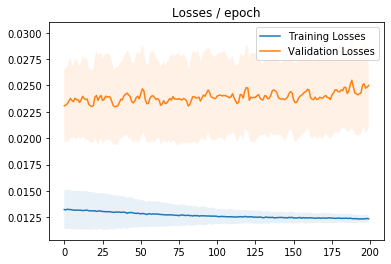

In [29]:
cv_plotter(cv_loss_trn, cv_loss_val)

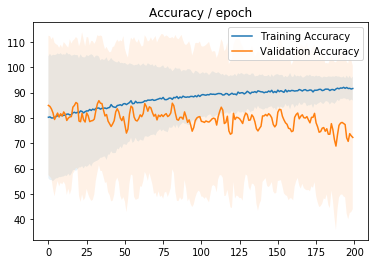

In [30]:
cv_plotter(cv_accs_trn, cv_accs_val, title='acc')

[]

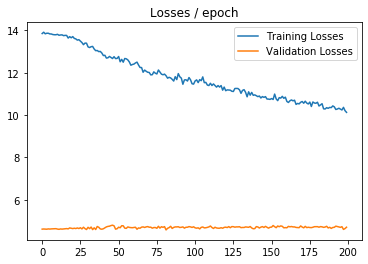

In [56]:
plt.title("Losses / epoch")
plt.plot(train_losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.legend()
plt.plot()

[]

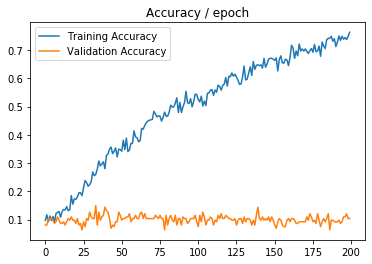

In [57]:
plt.title("Accuracy / epoch")
plt.plot(np.array(train_accs)/train_cnt, label='Training Accuracy')
plt.plot(np.array(val_accs)/val_cnt, label='Validation Accuracy')
plt.legend()
plt.plot()

In [55]:
conv(x).argmax(axis=1)

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 6, 1, 6, 7, 5, 0, 2, 6, 5, 2, 0, 8, 7, 8, 7, 6, 3, 8, 8, 3, 7, 5, 8,
        4, 6, 2, 8, 3, 3, 3, 1, 8, 3, 1, 1, 2, 1, 4, 3, 1, 6, 2, 9, 0, 1],
       grad_fn=<NotImplemented>)

## Training - Regression

In [ ]:
conv = ConvNet(ctype='regression')

EPOCHS = range(200)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

cv_loss_trn, cv_loss_val = [], []
cv_accs_trn, cv_accs_val = [], []
for i, (trn_idx, val_idx) in enumerate(kfold.split(X_train)):
    print("Working on {}th Fold".format(i))
    
    train_reg_ds = TensorDataset(X_train[trn_idx], y_reg_train[trn_idx])
    val_reg_ds = TensorDataset(X_train[val_idx], y_reg_train[val_idx])
    
    train_reg_loader = DataLoader(train_reg_ds, batch_size=128, shuffle=True)
    val_reg_loader = DataLoader(val_reg_ds, batch_size=128, shuffle=True)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in EPOCHS:

        train_batch_loss = 0
        cnt = 0
        conv.train()
        for x, y in train_reg_loader:

            optimizer.zero_grad()
            y_pred = conv(x)

            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            
            print(y_pred[:3], y[:3])

            train_batch_loss += loss.item()
            cnt += 1

        train_losses.append(train_batch_loss / cnt)

        val_batch_loss = 0
        cnt = 0
        conv.eval()
        for x, y in val_reg_loader:
            y_pred = conv(x)
            loss = loss_fn(y_pred, y)

            val_batch_loss += loss.item()
            cnt += 1

        val_losses.append(val_batch_loss / cnt)

        print("EPOCH: {}".format(epoch))
        print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
        
    cv_loss_trn.append(train_losses)
    
    cv_loss_val.append(val_losses)
    print("\n")

Working on 0th Fold


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[-0.8860],
        [-0.2666],
        [-1.4569]], grad_fn=<SliceBackward>) tensor([20, 65, 18])
tensor([[3.7514],
        [2.5064],
        [3.3119]], grad_fn=<SliceBackward>) tensor([73, 67, 74])
tensor([[6.4337],
        [7.1279],
        [7.2359]], grad_fn=<SliceBackward>) tensor([68, 79, 63])
tensor([[10.5921],
        [ 9.4735],
        [11.9652]], grad_fn=<SliceBackward>) tensor([90, 22, 60])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([111])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor([[14.7119],
        [14.5639],
        [16.4172]], grad_fn=<SliceBackward>) tensor([24, 23, 70])


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\modules\loss.py:88: UserWarning: Using a target size (torch.Size([70])) that is different to the input size (torch.Size([70, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


EPOCH: 0
[LOSS] train: 258.504, val: 52.225
tensor([[18.1485],
        [18.8382],
        [17.6593]], grad_fn=<SliceBackward>) tensor([22, 64, 23])
tensor([[21.3063],
        [22.3260],
        [21.4384]], grad_fn=<SliceBackward>) tensor([67, 53, 74])
tensor([[28.2925],
        [26.0352],
        [29.0171]], grad_fn=<SliceBackward>) tensor([20, 81, 63])
tensor([[32.1914],
        [31.2046],
        [32.3236]], grad_fn=<SliceBackward>) tensor([63, 80, 46])
tensor([[35.1348],
        [38.9005],
        [38.1344]], grad_fn=<SliceBackward>) tensor([80, 62, 24])
EPOCH: 1
[LOSS] train: 168.073, val: 37.531
tensor([[41.2028],
        [36.8497],
        [44.8961]], grad_fn=<SliceBackward>) tensor([66, 81, 59])
tensor([[47.0528],
        [48.3502],
        [44.3552]], grad_fn=<SliceBackward>) tensor([70, 58, 67])
tensor([[50.6605],
        [49.2132],
        [51.8926]], grad_fn=<SliceBackward>) tensor([94, 93, 45])
tensor([[59.8185],
        [56.6967],
        [56.7938]], grad_fn=<SliceBackward

tensor([[63.6575],
        [69.3416],
        [64.9629]], grad_fn=<SliceBackward>) tensor([63, 54, 21])
tensor([[59.7338],
        [63.7904],
        [65.8307]], grad_fn=<SliceBackward>) tensor([73, 65, 73])
EPOCH: 15
[LOSS] train: 70.82, val: 19.366
tensor([[68.1098],
        [60.2084],
        [60.8114]], grad_fn=<SliceBackward>) tensor([64, 48, 94])
tensor([[65.0466],
        [63.4110],
        [64.2477]], grad_fn=<SliceBackward>) tensor([59, 73, 51])
tensor([[62.1667],
        [69.3335],
        [65.3916]], grad_fn=<SliceBackward>) tensor([69, 68, 72])
tensor([[66.0738],
        [64.6467],
        [66.0893]], grad_fn=<SliceBackward>) tensor([23, 68, 59])
tensor([[61.8784],
        [66.2549],
        [65.0042]], grad_fn=<SliceBackward>) tensor([74, 43, 34])
EPOCH: 16
[LOSS] train: 71.482, val: 20.144
tensor([[67.3831],
        [62.2787],
        [61.6711]], grad_fn=<SliceBackward>) tensor([80, 68, 74])
tensor([[62.4887],
        [61.3032],
        [61.5157]], grad_fn=<SliceBackward>

In [1]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='binary')

EPOCHS = range(100)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_binary_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_binary_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

NameError: name 'ConvNet' is not defined

In [72]:
pred = torch.tensor([0.1, 0.2, 0.3, 0.9], dtype=torch.float)
true = torch.tensor([0, 0, 0, 1], dtype=torch.float)
loss_fn(pred, true)

tensor(0.1976)